In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### - 데이터 출처
- 베어링 마모 상태에 따라 수집된 센서데이터

In [2]:
%cd /Users/kisehyun/OPTIMUM/크몽/20210806_index_sort/DataChallenge (2)/DataReference

/Users/kisehyun/OPTIMUM/크몽/20210806_index_sort/DataChallenge (2)/DataReference


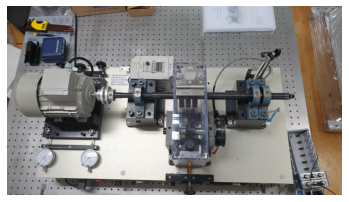

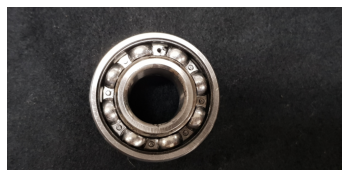

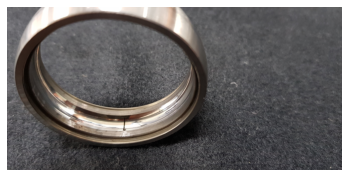

In [3]:
Simulator = plt.imread('Simulator.jpg')
plt.imshow(Simulator)
plt.axis('off')
plt.show()

Bearing = plt.imread('Bearing.jpg')
plt.imshow(Bearing)
plt.axis('off')
plt.show()

OuterRingFault = plt.imread('OuterRingFault.jpg')
plt.imshow(OuterRingFault)
plt.axis('off')
plt.show()

DataFrame 행,열 생략 방지

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',   5000)

# 데이터 불러오기

### Process 및 Record 데이터 불러오기 (Normal, Abnormal 각 1개씩)

In [5]:
%cd /Users/kisehyun/OPTIMUM/크몽/20210806_index_sort/DataChallenge (2)/Data

/Users/kisehyun/OPTIMUM/크몽/20210806_index_sort/DataChallenge (2)/Data


In [6]:
NormalProcess   = pd.read_csv('NormalProcess')
AbnormalProcess = pd.read_csv('AbnormalProcess')

NormalRecord   = pd.read_csv('NormalRecord',   header = None, dtype = 'int64')
AbnormalRecord = pd.read_csv('AbnormalRecord', header = None, dtype = 'int64')

### Process 데이터 살펴보기
[NormalProcess / AbnormalProcess]

0열 : 시간열 (s) - Hz = 20000

1열 : x 방향 가속도

2열 : y 방향 가속도

### Record 데이터 살펴보기
[NormalRecord / AbnormalRecord]

데이터 수집 중 공정 수행(장비 작동)이 정지되었던 시간(break time)을 기록한 데이터

0열 : "작동 정지" 시작 시간(s)

1열 : "작동 정지" 끝 시간(s, 장비 작동 시작 시간)

In [20]:
AbnormalRecord

,0,1
0,51,54
1,100,110
2,126,132
3,151,156
4,170,177
5,195,198
6,223,231
7,311,317
8,338,340
9,454,459


.

.

.



# [1단계] 공정 데이터(Process) & 기록 데이터(Record) 데이터 인덱싱 

## 실제로 공정이 수행되고 있는 데이터만 추출 (장비가 작동 중인 데이터)

Record 데이터 time에 맞게 Process 데이터 내 필요한 데이터 추출

추출된 데이터는 모두 이어붙여 하나의 NormalData 및 AbnormalData로 변환

#### [필수] 추출 후 데이터 이름(변수명) : 
- NormalData
- AbnormalData

! 힌트 : np.where함수를 사용할 경우 처음 데이터와 마지막 데이터는 for 구문 밖에서 직접 인덱싱하는 것이 편리함

In [23]:
FirstDataStartPoint_Normal = np.where(NormalProcess.iloc[:,0].values == 39)[0][0]
EndDataStartPoint_Normal   = np.where(NormalProcess.iloc[:,0].values == 1772)[0][0]

NormalData = NormalProcess.iloc[:FirstDataStartPoint_Normal,:]


for i in range(NormalRecord.shape[0]-1):
    startpoint = np.where(NormalProcess.iloc[:,0].values == NormalRecord. iloc[i][1])[0][0]
    endpoint = np.where(NormalProcess.iloc[:,0].values == NormalRecord. iloc[i+1][0])[0][0]
    
    tempdata = NormalProcess.iloc[startpoint:endpoint,:]
    
    NormalData = np.concatenate([NormalData, tempdata])

NormalData = pd.DataFrame(np.concatenate([NormalData, NormalProcess.iloc[EndDataStartPoint_Normal:,:]]))
NormalData.shape

(30000000, 3)

In [22]:
FirstDataStartPoint_Abnormal = np.where(AbnormalProcess.iloc[:,0].values == 51)[0][0]
EndDataStartPoint_Abnormal   = np.where(AbnormalProcess.iloc[:,0].values == 1539)[0][0]

AbnormalData = AbnormalProcess.iloc[:FirstDataStartPoint_Abnormal,:]


for i in range(AbnormalRecord.shape[0]-1):
    startpoint = np.where(AbnormalProcess.iloc[:,0].values == AbnormalRecord. iloc[i][1])[0][0]
    endpoint = np.where(AbnormalProcess.iloc[:,0].values == AbnormalRecord. iloc[i+1][0])[0][0]
    
    tempdata = AbnormalProcess.iloc[startpoint:endpoint,:]
    
    AbnormalData = np.concatenate([AbnormalData, tempdata])

AbnormalData = pd.DataFrame(np.concatenate([AbnormalData, AbnormalProcess.iloc[EndDataStartPoint_Abnormal:,:]]))
AbnormalData.shape

(30000000, 3)

In [24]:
NormalData.shape, AbnormalData.shape

((30000000, 3), (30000000, 3))

.

.

.



### 1단계 결과물 제출용 데이터 파일로 저장 

In [26]:
StudentNo = 2

# 아래는 수정 금지
NormalShape   = pd.DataFrame(NormalData.shape)
AbnormalShape = pd.DataFrame(AbnormalData.shape)


Path1 = './Result/ST%d_DC1_1'%StudentNo
Path2 = './Result/ST%d_DC1_2'%StudentNo

NormalShape.to_csv(Path1 , sep=',' , header=None , index=None)
AbnormalShape.to_csv(Path2 , sep=',' , header=None , index=None)

.

.

.



# [2단계] Normal / Abnormal 데이터 분할

## 각 데이터를 10초 단위로 분할

(시작을 1초로 가정할 시)

NormalData의 1~10초  -> Normal_1

NormalData의 11~20초 -> Normal_2

NormalData의 21~30초 -> Normal_3

              .
              .
              .


#### [필수] 분할 후 데이터 이름(변수명) : 
- Normal_1~n
- Abnormal_1~n

In [27]:
# 데이터 분할을 위한 시간열 재생성 (코드 수정 x)
Hz = 20000

NormalData_time   = np.arange(0, NormalData.shape[0] / Hz,   1 / Hz)
AbnormalData_time = np.arange(0, AbnormalData.shape[0] / Hz, 1 / Hz)

NormalData.iloc[:,0]   = NormalData_time
AbnormalData.iloc[:,0] = AbnormalData_time

NormalData.columns   = ['time', 'x_acc', 'y_acc']
AbnormalData.columns = ['time', 'x_acc', 'y_acc']

In [28]:
NormalData['t_int'] = (NormalData.time.astype(int) / 10).astype(int) + 1

In [29]:
AbnormalData['t_int'] = (AbnormalData.time.astype(int) / 10).astype(int) + 1

In [30]:
for t in NormalData.t_int.unique() :
    globals()[f'Normal_{t}'] = NormalData[NormalData.t_int == t].iloc[:, :-1]

In [31]:
Normal_1.head()

,time,x_acc,y_acc
0,0.00000,0.385451,-0.116455
1,0.00005,-0.001705,-0.072191
2,0.00010,0.025332,-0.024551
3,0.00015,0.512375,-0.128459
4,0.00020,0.159016,0.003958


In [34]:
Normal_150.tail()

,time,x_acc,y_acc
29999995,1499.99975,0.052369,-0.288260
29999996,1499.99980,0.043732,-0.065439
29999997,1499.99985,0.107570,-0.085695
29999998,1499.99990,0.146248,-0.181726
29999999,1499.99995,0.048239,-0.006545


In [33]:
for t in AbnormalData.t_int.unique() :
    globals()[f'Abnormal_{t}'] = AbnormalData[AbnormalData.t_int == t].iloc[:, :-1]

In [35]:
Abnormal_1.head()

,time,x_acc,y_acc
0,0.00000,-0.136515,0.061351
1,0.00005,-0.083943,-0.343402
2,0.00010,0.128223,-0.917710
3,0.00015,0.610009,-0.290510
4,0.00020,0.383574,0.443973


In [36]:
Abnormal_150.tail()

,time,x_acc,y_acc
29999995,1499.99975,-0.581876,0.508118
29999996,1499.99980,0.113954,0.137876
29999997,1499.99985,0.552180,0.014461
29999998,1499.99990,-0.005836,-0.122832
29999999,1499.99995,-0.437303,0.148379


.

.

.



### 2단계 결과물 제출용 데이터 파일로 저장 

In [38]:
# StudentNo = 2

Path1 = './Result/ST%d_DC2_1'%StudentNo
Path2 = './Result/ST%d_DC2_2'%StudentNo


Normal_150.to_csv(Path1 , sep=',' , header=None , index=None)
Abnormal_150.to_csv(Path2 , sep=',' , header=None , index=None)

.

.

.



# 3단계 데이터 특징 추출

2단계에서 추출한 데이터에 대하여 각 센서(열) 별로 아래 10개 특징값 순서대로 추출 (time domain만 추출! / frequency domain X)
- Max, Min, Mean, RMS, Variance, Skewness, Kurtosis, Crest factor, Impulse factor, Shape factor 순서대로

In [45]:
import scipy.stats as sp

def rms(x): # RMS 함수 정의
    return np.sqrt(np.mean(x**2))


#### [필수] 추출 후 특징데이터 (총 2개) 이름(변수명) : 
- (Normal 특징데이터) Feature_Normal
- (Abnormal 특징데이터) Feature_Abnormal

In [77]:
f1 = []; f2 = []; f3 = []; f4 = []; f5 = []; f6 = []; f7 = []; f8 = []; f9 = []; f10 = [];
for i in range(1, 151) :
    df = globals()[f'Normal_{i}']
    
    Max = df.x_acc.max()
    Min = df.x_acc.min()
    Mean = df.x_acc.mean()
    RMS = rms(df.x_acc)
    Var = df.x_acc.var()
    Skew = df.x_acc.skew()
    Kurt = df.x_acc.kurtosis()
    cf = Max / RMS
    If = Max / Mean
    Sf = RMS / Mean
    
    
    f1.append(Max)
    f2.append(Min)
    f3.append(Mean)
    f4.append(RMS)
    f5.append(Var)
    f6.append(Skew)
    f7.append(Kurt)
    f8.append(cf)
    f9.append(If)
    f10.append(Sf)

In [78]:
FeatureNormal_x = pd.DataFrame(index = [f"Normal_{i}" for i in range(1, 151)],data = {'MAX' : f1, 'MIN' : f2, 'MEAN' : f3, 'RMS' : f4,
                                                                   'VAR' : f5, 'SKEW' : f6, 'KURTOSIS' : f7, 'CrestFactor' : f8,
                                                                   'InpulseFactor' : f9, 'ShapeFactor' : f10})

In [79]:
FeatureNormal_x.columns = [f'x_acc_{c}' for c in FeatureNormal_x.columns]

In [80]:
f1 = []; f2 = []; f3 = []; f4 = []; f5 = []; f6 = []; f7 = []; f8 = []; f9 = []; f10 = [];
for i in range(1, 151) :
    df = globals()[f'Normal_{i}']
    
    Max = df.y_acc.max()
    Min = df.y_acc.min()
    Mean = df.y_acc.mean()
    RMS = rms(df.y_acc)
    Var = df.y_acc.var()
    Skew = df.y_acc.skew()
    Kurt = df.y_acc.kurtosis()
    cf = Max / RMS
    If = Max / Mean
    Sf = RMS / Mean
    
    
    f1.append(Max)
    f2.append(Min)
    f3.append(Mean)
    f4.append(RMS)
    f5.append(Var)
    f6.append(Skew)
    f7.append(Kurt)
    f8.append(cf)
    f9.append(If)
    f10.append(Sf)

In [83]:
FeatureNormal_y = pd.DataFrame(index = [f"Normal_{i}" for i in range(1, 151)],data = {'MAX' : f1, 'MIN' : f2, 'MEAN' : f3, 'RMS' : f4,
                                                                   'VAR' : f5, 'SKEW' : f6, 'KURTOSIS' : f7, 'CrestFactor' : f8,
                                                                   'InpulseFactor' : f9, 'ShapeFactor' : f10})

In [84]:
FeatureNormal_y.columns = [f'y_acc_{c}' for c in FeatureNormal_y.columns]

In [102]:
Feature_Normal = pd.concat([FeatureNormal_x, FeatureNormal_y], axis = 1).T

In [103]:
Feature_Normal

,Normal_1,Normal_2,Normal_3,Normal_4,Normal_5,Normal_6,Normal_7,Normal_8,Normal_9,Normal_10,Normal_11,Normal_12,Normal_13,Normal_14,Normal_15,Normal_16,Normal_17,Normal_18,Normal_19,Normal_20,Normal_21,Normal_22,Normal_23,Normal_24,Normal_25,Normal_26,Normal_27,Normal_28,Normal_29,Normal_30,Normal_31,Normal_32,Normal_33,Normal_34,Normal_35,Normal_36,Normal_37,Normal_38,Normal_39,Normal_40,Normal_41,Normal_42,Normal_43,Normal_44,Normal_45,Normal_46,Normal_47,Normal_48,Normal_49,Normal_50,Normal_51,Normal_52,Normal_53,Normal_54,Normal_55,Normal_56,Normal_57,Normal_58,Normal_59,Normal_60,Normal_61,Normal_62,Normal_63,Normal_64,Normal_65,Normal_66,Normal_67,Normal_68,Normal_69,Normal_70,Normal_71,Normal_72,Normal_73,Normal_74,Normal_75,Normal_76,Normal_77,Normal_78,Normal_79,Normal_80,Normal_81,Normal_82,Normal_83,Normal_84,Normal_85,Normal_86,Normal_87,Normal_88,Normal_89,Normal_90,Normal_91,Normal_92,Normal_93,Normal_94,Normal_95,Normal_96,Normal_97,Normal_98,Normal_99,Normal_100,Normal_101,Normal_102,Normal_103,Normal_104,Normal_105,Normal_106,Normal_107,Normal_108,Normal_109,Normal_110,Normal_111,Normal_112,Normal_113,Normal_114,Normal_115,Normal_116,Normal_117,Normal_118,Normal_119,Normal_120,Normal_121,Normal_122,Normal_123,Normal_124,Normal_125,Normal_126,Normal_127,Normal_128,Normal_129,Normal_130,Normal_131,Normal_132,Normal_133,Normal_134,Normal_135,Normal_136,Normal_137,Normal_138,Normal_139,Normal_140,Normal_141,Normal_142,Normal_143,Normal_144,Normal_145,Normal_146,Normal_147,Normal_148,Normal_149,Normal_150
x_acc_MAX,1.546920,1.908916,2.373429,2.004297,1.680228,1.427506,1.367799,1.504487,1.575459,1.114702,1.360664,1.137608,1.303961,1.376811,1.958109,1.484584,1.603623,1.416241,1.160139,2.023073,1.276549,1.334003,1.244255,2.000542,1.464306,1.495099,1.316353,1.346395,1.277300,1.486086,1.772604,2.167271,1.781617,1.469939,1.478201,1.934827,1.607002,1.424126,1.330248,1.438771,1.623149,2.058371,1.849585,1.370803,1.560814,1.572830,1.603998,1.449286,1.700130,1.651689,1.648684,1.881879,1.417367,1.412485,2.149997,1.248010,1.355407,1.223226,1.366297,1.279177,1.377938,1.101934,1.342640,1.880377,1.356909,1.101934,1.767347,1.263030,1.723412,1.228107,1.305088,1.395587,1.413987,1.875120,1.278051,1.183421,1.242752,1.665207,1.374934,1.391832,1.407979,1.561565,1.464306,1.511621,1.436894,1.461678,1.545793,1.628782,1.789127,1.314100,2.239370,1.639672,1.499229,1.329872,1.535279,1.154506,1.479327,1.315978,1.558185,1.438396,1.270916,1.183797,1.048611,1.515752,1.649435,1.431261,1.270916,1.899904,1.507491,1.732049,1.622023,1.561940,1.555557,1.475947,1.694122,1.268288,1.511246,1.169903,1.312223,1.681354,1.389579,2.004673,1.645305,1.621272,1.524389,1.587475,1.904410,1.583720,1.340011,1.668587,1.634790,1.311472,1.323488,1.299455,1.432763,1.340386,1.109069,1.745567,1.152253,1.289316,1.442151,1.589353,1.543916,1.715151,1.313349,1.223977,1.493221,1.631411,1.773731,1.524013
x_acc_MIN,-1.403503,-1.555211,-1.835721,-1.683262,-1.104218,-0.996445,-1.115107,-0.866141,-0.997571,-0.905945,-1.173312,-0.910076,-1.068168,-1.240530,-1.211615,-1.306620,-1.730952,-1.143271,-0.972412,-2.035871,-1.111352,-1.379470,-1.225509,-1.192464,-1.059156,-1.264563,-1.004706,-1.504892,-1.034747,-1.429414,-2.511648,-1.207484,-1.693776,-0.963775,-1.200349,-1.448940,-1.888669,-1.530052,-1.257803,-1.050519,-1.286718,-1.905567,-1.539815,-1.070797,-1.199974,-1.281461,-1.029490,-1.161671,-1.469594,-1.334033,-1.585628,-2.068165,-1.214995,-1.015596,-1.623931,-1.074927,-1.214619,-0.829340,-1.098960,-1.480108,-1.168055,-0.797422,-1.045637,-1.392989,-1.404254,-1.148153,-1.436173,-1.122993,-1.046013,-1.000951,-1.075678,-0.887545,-1.122993,-1.224758,-0.986681,-0.889047,-0.764001,-2.257049,-0.834598,-1.082438,-0.951383,-1.750855,-1.018225,-1.276955,-0.904819,-1.020853,-1.279959,-1.350180,-1.282587,-1.186080,-1.927722,-1.340417,-1.289722,-1.007710,-1.370833,-1.136887,-1.300612,-1.226635,-1.119238,-1.120740,-1.147777,-0.903317,-0.733209,-1.146651,-0.978420,-1.388107,-1.050143,-1.792161,-1.8345

In [90]:
f1 = []; f2 = []; f3 = []; f4 = []; f5 = []; f6 = []; f7 = []; f8 = []; f9 = []; f10 = [];
for i in range(1, 151) :
    df = globals()[f'Abnormal_{i}']
    
    Max = df.x_acc.max()
    Min = df.x_acc.min()
    Mean = df.x_acc.mean()
    RMS = rms(df.x_acc)
    Var = df.x_acc.var()
    Skew = df.x_acc.skew()
    Kurt = df.x_acc.kurtosis()
    cf = Max / RMS
    If = Max / Mean
    Sf = RMS / Mean
    
    
    f1.append(Max)
    f2.append(Min)
    f3.append(Mean)
    f4.append(RMS)
    f5.append(Var)
    f6.append(Skew)
    f7.append(Kurt)
    f8.append(cf)
    f9.append(If)
    f10.append(Sf)

In [91]:
FeatureAbnormal_x = pd.DataFrame(index = [f"Abnormal_{i}" for i in range(1, 151)],data = {'MAX' : f1, 'MIN' : f2, 'MEAN' : f3, 'RMS' : f4,
                                                                   'VAR' : f5, 'SKEW' : f6, 'KURTOSIS' : f7, 'CrestFactor' : f8,
                                                                   'InpulseFactor' : f9, 'ShapeFactor' : f10})

In [92]:
FeatureAbnormal_x.columns = [f'x_acc_{c}' for c in FeatureAbnormal_x.columns]

In [93]:
f1 = []; f2 = []; f3 = []; f4 = []; f5 = []; f6 = []; f7 = []; f8 = []; f9 = []; f10 = [];
for i in range(1, 151) :
    df = globals()[f'Abnormal_{i}']
    
    Max = df.y_acc.max()
    Min = df.y_acc.min()
    Mean = df.y_acc.mean()
    RMS = rms(df.y_acc)
    Var = df.y_acc.var()
    Skew = df.y_acc.skew()
    Kurt = df.y_acc.kurtosis()
    cf = Max / RMS
    If = Max / Mean
    Sf = RMS / Mean
    
    
    f1.append(Max)
    f2.append(Min)
    f3.append(Mean)
    f4.append(RMS)
    f5.append(Var)
    f6.append(Skew)
    f7.append(Kurt)
    f8.append(cf)
    f9.append(If)
    f10.append(Sf)

In [94]:
FeatureAbnormal_y = pd.DataFrame(index = [f"Abnormal_{i}" for i in range(1, 151)],data = {'MAX' : f1, 'MIN' : f2, 'MEAN' : f3, 'RMS' : f4,
                                                                   'VAR' : f5, 'SKEW' : f6, 'KURTOSIS' : f7, 'CrestFactor' : f8,
                                                                   'InpulseFactor' : f9, 'ShapeFactor' : f10})

In [95]:
FeatureAbnormal_y.columns = [f'y_acc_{c}' for c in FeatureAbnormal_y.columns]

In [99]:
Feature_Abnormal = pd.concat([FeatureAbnormal_x, FeatureAbnormal_y], axis = 1).T

In [101]:
Feature_Abnormal

,Abnormal_1,Abnormal_2,Abnormal_3,Abnormal_4,Abnormal_5,Abnormal_6,Abnormal_7,Abnormal_8,Abnormal_9,Abnormal_10,Abnormal_11,Abnormal_12,Abnormal_13,Abnormal_14,Abnormal_15,Abnormal_16,Abnormal_17,Abnormal_18,Abnormal_19,Abnormal_20,Abnormal_21,Abnormal_22,Abnormal_23,Abnormal_24,Abnormal_25,Abnormal_26,Abnormal_27,Abnormal_28,Abnormal_29,Abnormal_30,Abnormal_31,Abnormal_32,Abnormal_33,Abnormal_34,Abnormal_35,Abnormal_36,Abnormal_37,Abnormal_38,Abnormal_39,Abnormal_40,Abnormal_41,Abnormal_42,Abnormal_43,Abnormal_44,Abnormal_45,Abnormal_46,Abnormal_47,Abnormal_48,Abnormal_49,Abnormal_50,Abnormal_51,Abnormal_52,Abnormal_53,Abnormal_54,Abnormal_55,Abnormal_56,Abnormal_57,Abnormal_58,Abnormal_59,Abnormal_60,Abnormal_61,Abnormal_62,Abnormal_63,Abnormal_64,Abnormal_65,Abnormal_66,Abnormal_67,Abnormal_68,Abnormal_69,Abnormal_70,Abnormal_71,Abnormal_72,Abnormal_73,Abnormal_74,Abnormal_75,Abnormal_76,Abnormal_77,Abnormal_78,Abnormal_79,Abnormal_80,Abnormal_81,Abnormal_82,Abnormal_83,Abnormal_84,Abnormal_85,Abnormal_86,Abnormal_87,Abnormal_88,Abnormal_89,Abnormal_90,Abnormal_91,Abnormal_92,Abnormal_93,Abnormal_94,Abnormal_95,Abnormal_96,Abnormal_97,Abnormal_98,Abnormal_99,Abnormal_100,Abnormal_101,Abnormal_102,Abnormal_103,Abnormal_104,Abnormal_105,Abnormal_106,Abnormal_107,Abnormal_108,Abnormal_109,Abnormal_110,Abnormal_111,Abnormal_112,Abnormal_113,Abnormal_114,Abnormal_115,Abnormal_116,Abnormal_117,Abnormal_118,Abnormal_119,Abnormal_120,Abnormal_121,Abnormal_122,Abnormal_123,Abnormal_124,Abnormal_125,Abnormal_126,Abnormal_127,Abnormal_128,Abnormal_129,Abnormal_130,Abnormal_131,Abnormal_132,Abnormal_133,Abnormal_134,Abnormal_135,Abnormal_136,Abnormal_137,Abnormal_138,Abnormal_139,Abnormal_140,Abnormal_141,Abnormal_142,Abnormal_143,Abnormal_144,Abnormal_145,Abnormal_146,Abnormal_147,Abnormal_148,Abnormal_149,Abnormal_150
x_acc_MAX,8.006157,8.193163,7.822905,7.862710,7.448517,9.128196,7.546151,8.038827,8.617495,8.121815,7.252873,7.720390,9.373783,7.434623,9.143968,7.587457,7.537138,8.032443,7.534885,8.511225,8.481183,7.896506,7.880735,7.582200,7.950580,7.463913,8.560042,7.021931,7.711753,6.834549,6.196925,5.576198,5.954717,7.761321,5.988889,7.695981,7.164252,6.367408,5.673832,6.183781,6.763201,5.576573,6.817651,6.664816,6.148483,7.020054,7.560045,7.914156,6.315587,7.378671,6.369286,7.124447,6.602105,7.508224,6.710254,7.952083,7.375667,7.921290,7.867967,6.469549,7.105671,5.737294,8.766575,7.166505,5.938195,6.882240,6.353890,5.599855,6.549533,6.938192,5.962228,8.476302,6.587460,6.163128,9.144719,6.163504,6.866844,6.021183,6.804884,6.390690,6.106050,7.971985,6.118442,7.511979,7.170260,6.892003,6.781226,6.773340,6.788361,7.078634,4.599483,5.288553,6.359523,4.722276,5.660689,5.359150,5.103800,5.543904,6.225464,6.018555,5.818781,6.258133,6.109054,6.823659,8.309573,5.588214,5.904023,6.157495,7.247616,6.293807,6.115062,6.600228,6.272028,6.721895,6.799626,6.529255,7.439504,6.597224,6.615624,6.652800,4.902899,5.468050,5.723775,5.446645,6.264142,6.157871,5.689979,6.727527,6.182279,7.745925,7.074504,5.861965,5.715139,7.041083,5.823662,6.916036,6.080890,6.327604,6.009918,6.122573,5.544655,6.991890,6.316714,5.732412,5.835679,6.217953,7.079010,6.202182,6.080890,6.235978
x_acc_MIN,-8.004685,-7.665595,-8.494357,-7.931459,-7.169915,-7.544303,-7.777874,-9.509750,-8.665967,-7.548809,-7.159400,-7.855230,-6.560078,-8.186434,-8.262664,-6.754219,-7.275810,-6.463946,-6.574347,-7.971264,-6.193575,-7.163155,-6.894286,-7.296839,-8.505622,-6.057639,-8.086923,-7.732812,-8.437278,-8.259660,-6.089182,-5.379083,-5.750843,-6.266049,-5.457190,-6.404990,-6.498118,-5.911188,-5.798909,-5.690385,-5.548064,-5.321253,-5.819562,-5.430528,-5.595004,-6.050879,-6.292711,-6.430150,-6.404615,-6.683247,-5.982535,-8.775242,-7.121473,-7.280692,-6.029099,-7.195074,-7.510882,-7.647945,-6.091059,-5.973523,-5.328388,-5.450055,-7.377574,-6.649450,-5.884526,-5.848101,-5.794027,-6.984035,-5.553322,-6.684749,-5.447426,-5.887155,-6.099696,-7.209719,-5.937474,-5.976527,-5.870256,-5.561207,-7.7316

.

.

.



### Data frame 형식으로 변환 및 데이터 확인 (코드수정x)

In [104]:
Feature_Normal_df = pd.DataFrame(Feature_Normal)
Feature_Normal_df

,Normal_1,Normal_2,Normal_3,Normal_4,Normal_5,Normal_6,Normal_7,Normal_8,Normal_9,Normal_10,Normal_11,Normal_12,Normal_13,Normal_14,Normal_15,Normal_16,Normal_17,Normal_18,Normal_19,Normal_20,Normal_21,Normal_22,Normal_23,Normal_24,Normal_25,Normal_26,Normal_27,Normal_28,Normal_29,Normal_30,Normal_31,Normal_32,Normal_33,Normal_34,Normal_35,Normal_36,Normal_37,Normal_38,Normal_39,Normal_40,Normal_41,Normal_42,Normal_43,Normal_44,Normal_45,Normal_46,Normal_47,Normal_48,Normal_49,Normal_50,Normal_51,Normal_52,Normal_53,Normal_54,Normal_55,Normal_56,Normal_57,Normal_58,Normal_59,Normal_60,Normal_61,Normal_62,Normal_63,Normal_64,Normal_65,Normal_66,Normal_67,Normal_68,Normal_69,Normal_70,Normal_71,Normal_72,Normal_73,Normal_74,Normal_75,Normal_76,Normal_77,Normal_78,Normal_79,Normal_80,Normal_81,Normal_82,Normal_83,Normal_84,Normal_85,Normal_86,Normal_87,Normal_88,Normal_89,Normal_90,Normal_91,Normal_92,Normal_93,Normal_94,Normal_95,Normal_96,Normal_97,Normal_98,Normal_99,Normal_100,Normal_101,Normal_102,Normal_103,Normal_104,Normal_105,Normal_106,Normal_107,Normal_108,Normal_109,Normal_110,Normal_111,Normal_112,Normal_113,Normal_114,Normal_115,Normal_116,Normal_117,Normal_118,Normal_119,Normal_120,Normal_121,Normal_122,Normal_123,Normal_124,Normal_125,Normal_126,Normal_127,Normal_128,Normal_129,Normal_130,Normal_131,Normal_132,Normal_133,Normal_134,Normal_135,Normal_136,Normal_137,Normal_138,Normal_139,Normal_140,Normal_141,Normal_142,Normal_143,Normal_144,Normal_145,Normal_146,Normal_147,Normal_148,Normal_149,Normal_150
x_acc_MAX,1.546920,1.908916,2.373429,2.004297,1.680228,1.427506,1.367799,1.504487,1.575459,1.114702,1.360664,1.137608,1.303961,1.376811,1.958109,1.484584,1.603623,1.416241,1.160139,2.023073,1.276549,1.334003,1.244255,2.000542,1.464306,1.495099,1.316353,1.346395,1.277300,1.486086,1.772604,2.167271,1.781617,1.469939,1.478201,1.934827,1.607002,1.424126,1.330248,1.438771,1.623149,2.058371,1.849585,1.370803,1.560814,1.572830,1.603998,1.449286,1.700130,1.651689,1.648684,1.881879,1.417367,1.412485,2.149997,1.248010,1.355407,1.223226,1.366297,1.279177,1.377938,1.101934,1.342640,1.880377,1.356909,1.101934,1.767347,1.263030,1.723412,1.228107,1.305088,1.395587,1.413987,1.875120,1.278051,1.183421,1.242752,1.665207,1.374934,1.391832,1.407979,1.561565,1.464306,1.511621,1.436894,1.461678,1.545793,1.628782,1.789127,1.314100,2.239370,1.639672,1.499229,1.329872,1.535279,1.154506,1.479327,1.315978,1.558185,1.438396,1.270916,1.183797,1.048611,1.515752,1.649435,1.431261,1.270916,1.899904,1.507491,1.732049,1.622023,1.561940,1.555557,1.475947,1.694122,1.268288,1.511246,1.169903,1.312223,1.681354,1.389579,2.004673,1.645305,1.621272,1.524389,1.587475,1.904410,1.583720,1.340011,1.668587,1.634790,1.311472,1.323488,1.299455,1.432763,1.340386,1.109069,1.745567,1.152253,1.289316,1.442151,1.589353,1.543916,1.715151,1.313349,1.223977,1.493221,1.631411,1.773731,1.524013
x_acc_MIN,-1.403503,-1.555211,-1.835721,-1.683262,-1.104218,-0.996445,-1.115107,-0.866141,-0.997571,-0.905945,-1.173312,-0.910076,-1.068168,-1.240530,-1.211615,-1.306620,-1.730952,-1.143271,-0.972412,-2.035871,-1.111352,-1.379470,-1.225509,-1.192464,-1.059156,-1.264563,-1.004706,-1.504892,-1.034747,-1.429414,-2.511648,-1.207484,-1.693776,-0.963775,-1.200349,-1.448940,-1.888669,-1.530052,-1.257803,-1.050519,-1.286718,-1.905567,-1.539815,-1.070797,-1.199974,-1.281461,-1.029490,-1.161671,-1.469594,-1.334033,-1.585628,-2.068165,-1.214995,-1.015596,-1.623931,-1.074927,-1.214619,-0.829340,-1.098960,-1.480108,-1.168055,-0.797422,-1.045637,-1.392989,-1.404254,-1.148153,-1.436173,-1.122993,-1.046013,-1.000951,-1.075678,-0.887545,-1.122993,-1.224758,-0.986681,-0.889047,-0.764001,-2.257049,-0.834598,-1.082438,-0.951383,-1.750855,-1.018225,-1.276955,-0.904819,-1.020853,-1.279959,-1.350180,-1.282587,-1.186080,-1.927722,-1.340417,-1.289722,-1.007710,-1.370833,-1.136887,-1.300612,-1.226635,-1.119238,-1.120740,-1.147777,-0.903317,-0.733209,-1.146651,-0.978420,-1.388107,-1.050143,-1.792161,-1.8345

In [105]:
Feature_Abnormal_df = pd.DataFrame(Feature_Abnormal)
Feature_Abnormal_df

,Abnormal_1,Abnormal_2,Abnormal_3,Abnormal_4,Abnormal_5,Abnormal_6,Abnormal_7,Abnormal_8,Abnormal_9,Abnormal_10,Abnormal_11,Abnormal_12,Abnormal_13,Abnormal_14,Abnormal_15,Abnormal_16,Abnormal_17,Abnormal_18,Abnormal_19,Abnormal_20,Abnormal_21,Abnormal_22,Abnormal_23,Abnormal_24,Abnormal_25,Abnormal_26,Abnormal_27,Abnormal_28,Abnormal_29,Abnormal_30,Abnormal_31,Abnormal_32,Abnormal_33,Abnormal_34,Abnormal_35,Abnormal_36,Abnormal_37,Abnormal_38,Abnormal_39,Abnormal_40,Abnormal_41,Abnormal_42,Abnormal_43,Abnormal_44,Abnormal_45,Abnormal_46,Abnormal_47,Abnormal_48,Abnormal_49,Abnormal_50,Abnormal_51,Abnormal_52,Abnormal_53,Abnormal_54,Abnormal_55,Abnormal_56,Abnormal_57,Abnormal_58,Abnormal_59,Abnormal_60,Abnormal_61,Abnormal_62,Abnormal_63,Abnormal_64,Abnormal_65,Abnormal_66,Abnormal_67,Abnormal_68,Abnormal_69,Abnormal_70,Abnormal_71,Abnormal_72,Abnormal_73,Abnormal_74,Abnormal_75,Abnormal_76,Abnormal_77,Abnormal_78,Abnormal_79,Abnormal_80,Abnormal_81,Abnormal_82,Abnormal_83,Abnormal_84,Abnormal_85,Abnormal_86,Abnormal_87,Abnormal_88,Abnormal_89,Abnormal_90,Abnormal_91,Abnormal_92,Abnormal_93,Abnormal_94,Abnormal_95,Abnormal_96,Abnormal_97,Abnormal_98,Abnormal_99,Abnormal_100,Abnormal_101,Abnormal_102,Abnormal_103,Abnormal_104,Abnormal_105,Abnormal_106,Abnormal_107,Abnormal_108,Abnormal_109,Abnormal_110,Abnormal_111,Abnormal_112,Abnormal_113,Abnormal_114,Abnormal_115,Abnormal_116,Abnormal_117,Abnormal_118,Abnormal_119,Abnormal_120,Abnormal_121,Abnormal_122,Abnormal_123,Abnormal_124,Abnormal_125,Abnormal_126,Abnormal_127,Abnormal_128,Abnormal_129,Abnormal_130,Abnormal_131,Abnormal_132,Abnormal_133,Abnormal_134,Abnormal_135,Abnormal_136,Abnormal_137,Abnormal_138,Abnormal_139,Abnormal_140,Abnormal_141,Abnormal_142,Abnormal_143,Abnormal_144,Abnormal_145,Abnormal_146,Abnormal_147,Abnormal_148,Abnormal_149,Abnormal_150
x_acc_MAX,8.006157,8.193163,7.822905,7.862710,7.448517,9.128196,7.546151,8.038827,8.617495,8.121815,7.252873,7.720390,9.373783,7.434623,9.143968,7.587457,7.537138,8.032443,7.534885,8.511225,8.481183,7.896506,7.880735,7.582200,7.950580,7.463913,8.560042,7.021931,7.711753,6.834549,6.196925,5.576198,5.954717,7.761321,5.988889,7.695981,7.164252,6.367408,5.673832,6.183781,6.763201,5.576573,6.817651,6.664816,6.148483,7.020054,7.560045,7.914156,6.315587,7.378671,6.369286,7.124447,6.602105,7.508224,6.710254,7.952083,7.375667,7.921290,7.867967,6.469549,7.105671,5.737294,8.766575,7.166505,5.938195,6.882240,6.353890,5.599855,6.549533,6.938192,5.962228,8.476302,6.587460,6.163128,9.144719,6.163504,6.866844,6.021183,6.804884,6.390690,6.106050,7.971985,6.118442,7.511979,7.170260,6.892003,6.781226,6.773340,6.788361,7.078634,4.599483,5.288553,6.359523,4.722276,5.660689,5.359150,5.103800,5.543904,6.225464,6.018555,5.818781,6.258133,6.109054,6.823659,8.309573,5.588214,5.904023,6.157495,7.247616,6.293807,6.115062,6.600228,6.272028,6.721895,6.799626,6.529255,7.439504,6.597224,6.615624,6.652800,4.902899,5.468050,5.723775,5.446645,6.264142,6.157871,5.689979,6.727527,6.182279,7.745925,7.074504,5.861965,5.715139,7.041083,5.823662,6.916036,6.080890,6.327604,6.009918,6.122573,5.544655,6.991890,6.316714,5.732412,5.835679,6.217953,7.079010,6.202182,6.080890,6.235978
x_acc_MIN,-8.004685,-7.665595,-8.494357,-7.931459,-7.169915,-7.544303,-7.777874,-9.509750,-8.665967,-7.548809,-7.159400,-7.855230,-6.560078,-8.186434,-8.262664,-6.754219,-7.275810,-6.463946,-6.574347,-7.971264,-6.193575,-7.163155,-6.894286,-7.296839,-8.505622,-6.057639,-8.086923,-7.732812,-8.437278,-8.259660,-6.089182,-5.379083,-5.750843,-6.266049,-5.457190,-6.404990,-6.498118,-5.911188,-5.798909,-5.690385,-5.548064,-5.321253,-5.819562,-5.430528,-5.595004,-6.050879,-6.292711,-6.430150,-6.404615,-6.683247,-5.982535,-8.775242,-7.121473,-7.280692,-6.029099,-7.195074,-7.510882,-7.647945,-6.091059,-5.973523,-5.328388,-5.450055,-7.377574,-6.649450,-5.884526,-5.848101,-5.794027,-6.984035,-5.553322,-6.684749,-5.447426,-5.887155,-6.099696,-7.209719,-5.937474,-5.976527,-5.870256,-5.561207,-7.7316

.

.

.



### 3단계 결과물 제출용 데이터 파일로 저장

In [ ]:
# StudentNo = 2

Path1 = './Result/ST%d_DC3_1'%StudentNo
Path2 = './Result/ST%d_DC3_2'%StudentNo

Feature_Normal_df.to_csv(  Path1 , sep=',' , header=None , index=None)
Feature_Abnormal_df.to_csv(Path2 , sep=',' , header=None , index=None)

.

.

.



# 4단계 t-Test 기반 P-value 오름차순 기준 상위 10개의 주요 특징 선택

- 3단계의 Feature_Normal_df 및 Feature_Abnormal_df 데이터 활용하여 특징별 P-value 계산

In [120]:
from scipy.stats import ttest_ind

In [122]:
p_list = []
for i in range(20) :
    n, a = Feature_Normal_df.iloc[i, :], Feature_Abnormal_df.iloc[i, :]
    
    result = ttest_ind(n, a)
    
    p = result.pvalue
    
    p_list.append(p)

.

.

.



### P-value 오름차순으로 재정렬
- 상위 P-value 확인

In [128]:
pv_df = pd.DataFrame({'FEATURE' : Feature_Normal.index, 'PVALUE' : p_list}).sort_values(by = 'PVALUE')

In [130]:
top10 = pv_df.tail(10)

In [131]:
top10

,FEATURE,PVALUE
8,x_acc_InpulseFactor,1.780672e-169
19,y_acc_ShapeFactor,7.757145e-124
18,y_acc_InpulseFactor,3.169184e-123
17,y_acc_CrestFactor,2.809721e-109
15,y_acc_SKEW,3.161138e-106
2,x_acc_MEAN,5.853861e-86
6,x_acc_KURTOSIS,1.594960e-77
12,y_acc_MEAN,1.913869e-64
5,x_acc_SKEW,7.549080e-25
7,x_acc_CrestFactor,1.086165e-04


.

.

.



### 최종 선택된 특징데이터 인덱싱


#### [필수] 추출 후 특징데이터 (총 1개) 이름(변수명) : 
- FeatureSelected

In [137]:
FeatureSelected_Normal = Feature_Normal_df.loc[top10.FEATURE.tolist()]

In [138]:
FeatureSelected_Abnormal = Feature_Abnormal_df.loc[top10.FEATURE.tolist()]

In [139]:
Rank = 10

# 특징 선택 코드 작성 

FeatureSelected = pd.DataFrame(np.concatenate([FeatureSelected_Normal, FeatureSelected_Abnormal] , axis=1)) # 정상/고장 데이터 합치기 

print(FeatureSelected.shape)

(10, 300)


In [140]:
FeatureSelected

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,11.169029,14.476117,18.515826,16.282350,13.944765,11.936703,11.707536,12.812755,13.442742,9.683421,11.858564,9.703592,11.264242,11.791516,16.442014,12.271077,13.175433,11.510910,9.535181,16.109664,10.198113,10.536329,9.991755,15.899201,11.562196,11.831773,10.339566,10.555879,9.747802,11.612288,11.760048,14.786632,12.765276,10.903007,11.220111,14.895492,12.335114,11.149011,10.557533,11.410849,13.123622,16.170844,14.896647,10.677444,12.142707,12.472152,12.363278,11.259074,13.063920,12.797287,12.616646,14.618222,11.088273,10.728742,16.538026,9.577725,10.363183,9.175598,10.608685,10.122504,8.864277,7.196907,9.330628,13.510555,9.900162,8.174585,13.418453,9.588679,13.239521,9.394203,10.170795,10.797936,10.960926,14.551506,9.626113,9.004294,9.321948,12.777159,10.464325,10.681804,10.870782,11.883722,11.021582,11.327726,10.564432,10.547882,11.181574,11.931132,13.107840,9.897207,16.362776,12.416008,11.776303,10.744481,12.808968,10.035421,12.727811,11.354661,13.400740,12.459213,11.110083,10.332836,9.370139,13.316868,14.458069,12.104625,10.812715,15.907859,12.525682,14.136482,13.470260,12.706651,12.314275,11.759394,13.401496,9.853340,11.677599,9.011945,10.221215,12.788718,8.773414,13.329527,11.336764,11.433083,11.162183,11.699041,14.218966,11.942924,10.145829,12.633480,12.563135,9.993159,10.035796,9.897832,10.934672,10.156757,8.352710,13.214181,8.729738,10.004251,10.999499,12.647025,12.005714,12.957907,9.967968,9.244200,11.223983,12.094711,13.075405,11.116621,43.040762,42.423613,40.865821,40.791058,38.728425,46.547967,38.290801,41.160385,44.570585,41.758327,36.709457,39.687016,48.023353,38.199785,47.124384,39.955158,39.844243,42.115768,40.185530,45.631418,45.405449,43.051812,42.795200,40.704742,43.466289,41.498693,46.554092,38.781000,42.550734,38.593772,31.181718,30.127811,34.247246,46.942619,37.280211,49.326159,46.178228,41.605666,37.184410,41.114499,45.407694,37.940683,46.019241,45.121381,41.006317,46.842128,51.132135,52.006463,41.347959,48.689449,41.588001,45.941240,43.498127,48.283313,42.917929,49.916510,47.668288,50.511133,48.902750,40.547237,35.475347,29.887374,48.634517,40.661267,35.400260,42.316145,38.810384,34.682222,40.435504,43.235405,36.801533,53.051629,41.438251,38.759908,57.476635,38.340349,43.429082,37.558421,43.043169,40.081253,38.713110,49.447030,38.646910,47.029593,44.321157,43.524189,42.888721,41.619928,42.115546,43.621262,22.824507,27.829660,36.277793,27.745240,34.102944,33.295884,32.241374,34.700473,39.963500,38.448158,37.548565,39.674818,38.910490,43.716193,52.242663,35.317419,36.968115,38.569598,45.694319,39.134050,38.337286,41.378417,38.326537,41.476243,42.188435,40.448626,45.399065,40.128465,40.522806,40.367463,24.484906,28.650759,32.042466,30.918625,37.317136,37.329382,34.415741,41.454839,38.403518,47.686464,44.497401,36.632989,35.670959,43.743767,36.975435,43.389624,38.952347,40.696918,37.834448,38.421910,34.794222,44.176848,38.646598,35.05

.

.

.



### 4단계 결과물 제출용 데이터 파일로 저장 

In [ ]:
# StudentNo = 2

Path = './Result/ST%d_DC4'%StudentNo

FeatureSelected.to_csv( Path , sep=',' , header=None , index=None)